### Transformer Position Encoding
Transformer架构使用堆栈的attention层代替了CNN和RNN。这使得它可以简单的学习长距离依赖。但是它没有包含任何序列中物品的相对位置的信息。

为了让模型能够访问这些信息。Transformer对输入使用了position encoding。

这个encoding是一个sin和cos的向量。其中每个sin, cos的pair以不同的频率旋转。

相近的位置将会拥有相似的position-encoding向量。

In [0]:
import numpy as np
import matplotlib.pyplot as plt

角速度范围为<code>1 [rads/step]</code>到<code>min_rate [rads/step]</code>，步长为向量深度。

角速度的式子可写作：
$$angle\_rate_d=(min\_rate)^{d/d_{max}}$$

In [0]:
num_positions = 50
depth = 512
min_rate = 1/10000

assert depth%2 == 0, "Depth must be even."
angle_rate_exponents = np.linspace(0, 1, depth//2) # 步长为向量深度//2
angle_rates = min_rate**(angle_rate_exponents)

指数项从0到1，这会使angle_rates指数级的从1减少到min_rate。

Text(0, 0.5, 'Angle rate [rads/step]')

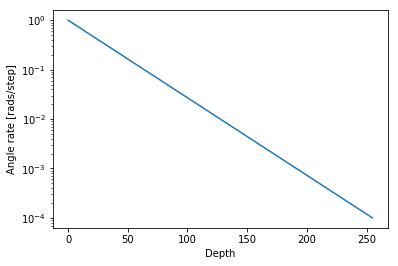

In [3]:
plt.semilogy(angle_rates)
plt.xlabel('Depth')
plt.ylabel('Angle rate [rads/step]')


对angle rates和positions实施broadcast的乘法可看作一个向量深度的函数（function of depth），其给出了一个position encoding angles的映射（map）。

In [0]:
positions = np.arange(num_positions) 
angle_rads = (positions[:, np.newaxis])*angle_rates[np.newaxis, :]

In [5]:
angle_rads.shape

(50, 256)

In [6]:
angle_rads

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.64525526e-01, 9.30309490e-01, ...,
        1.07491110e-04, 1.03677920e-04, 1.00000000e-04],
       [2.00000000e+00, 1.92905105e+00, 1.86061898e+00, ...,
        2.14982221e-04, 2.07355839e-04, 2.00000000e-04],
       ...,
       [4.70000000e+01, 4.53326997e+01, 4.37245460e+01, ...,
        5.05208219e-03, 4.87286223e-03, 4.70000000e-03],
       [4.80000000e+01, 4.62972252e+01, 4.46548555e+01, ...,
        5.15957330e-03, 4.97654015e-03, 4.80000000e-03],
       [4.90000000e+01, 4.72617508e+01, 4.55851650e+01, ...,
        5.26706441e-03, 5.08021807e-03, 4.90000000e-03]])

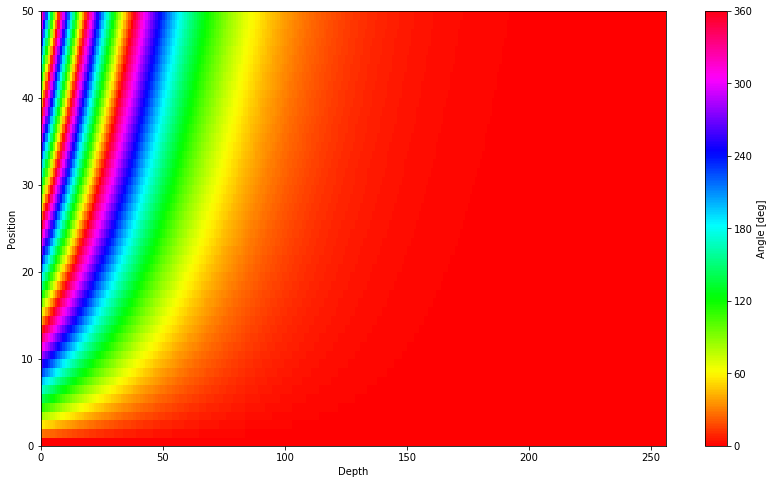

In [7]:
plt.figure(figsize = (14,8))
plt.pcolormesh(
    # 转换成角度并且在360度以内
    angle_rads*180/(2*np.pi) % 360,
    # 使用循环的colormap使得color(0) == color(360)
    cmap='hsv', vmin=0, vmax=360)

plt.xlim([0,len(angle_rates)])
plt.ylabel('Position')
plt.xlabel('Depth')
bar = plt.colorbar(label='Angle [deg]')
bar.set_ticks(np.linspace(0,360,6+1))

未经处理的角度不是一个好的模型输入（它们无限制或者不连续）。所以要使用sin和cos：

In [0]:
sines = np.sin(angle_rads)
cosines = np.cos(angle_rads)
pos_encoding = np.concatenate([sines, cosines], axis=-1)

In [9]:
pos_encoding.shape

(50, 512)

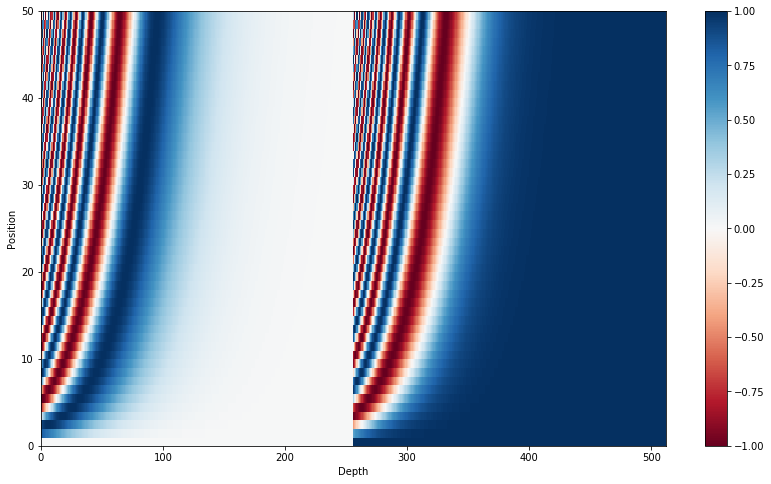

In [10]:
plt.figure(figsize=(14,8))
plt.pcolormesh(pos_encoding, 
               # 使用分离的colormap使得我们能看到0在哪里.
               cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()

### Nearby postions
相近位置会拥有近似的position-encoding向量。
为了证明这点我们比较一个位置的encoding(position 20)和所有其他位置。

In [0]:
pos_encoding_at_20 = pos_encoding[20]

dots = np.dot(pos_encoding,pos_encoding_at_20)
SSE = np.sum((pos_encoding - pos_encoding_at_20)**2, axis=1)

不管你如何比较这些向量，你会发现他们在20的时候最相似，并且离得越远越分离。

Text(0.5, 0, 'Position')

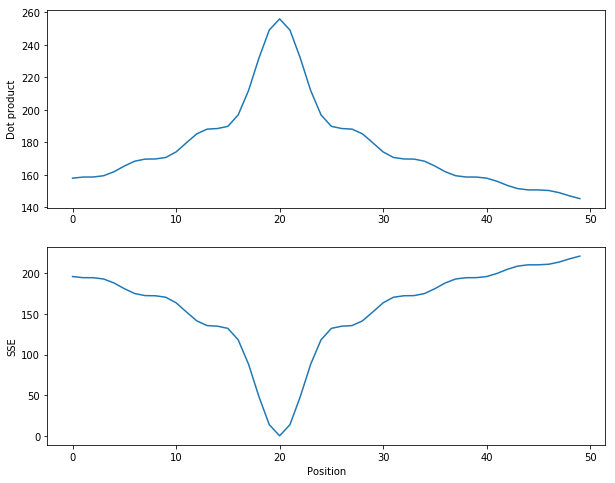

In [12]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylabel('Dot product')
plt.subplot(2,1,2)
plt.plot(SSE)
plt.ylabel('SSE')
plt.xlabel('Position')

### Relative positions
[论文](https://arxiv.org/pdf/1706.03762.pdf)的3.5小节中解释到，相对位置encoding能被写成一个当前位置的线性方程。

为了证明这点，我们构建矩阵来计算这些相对位置encoding。

In [0]:
def transition_matrix(position_delta, angle_rates = angle_rates):
    # 作为矩阵乘法实现：
    #    sin(a+b) = sin(a)*cos(b)+cos(a)*sin(b)
    #    cos(a+b) = cos(a)*cos(b)-sin(a)*sin(b)

    # b
    angle_delta = position_delta*angle_rates

    # sin(b), cos(b)
    sin_delta = np.sin(angle_delta)
    cos_delta = np.cos(angle_delta)

    I = np.eye(len(angle_rates))

    # sin(a+b) = sin(a)*cos(b)+cos(a)*sin(b)
    update_sin = np.concatenate([I*cos_delta, I*sin_delta], axis=0)

    # cos(a+b) = cos(a)*cos(b)-sin(a)*sin(b)
    update_cos = np.concatenate([-I*sin_delta, I*cos_delta], axis=0)

    return np.concatenate([update_sin, update_cos], axis=-1)

举个例子，创建矩阵从当前position encoding来计算10步以前的位置。

In [0]:
position_delta = -10
update = transition_matrix(position_delta)

对每个encoding向量应用这个矩阵使得position encoding向量退后了10步，实现了偏移position-encoding映射:


Text(0.5, 0, 'Depth')

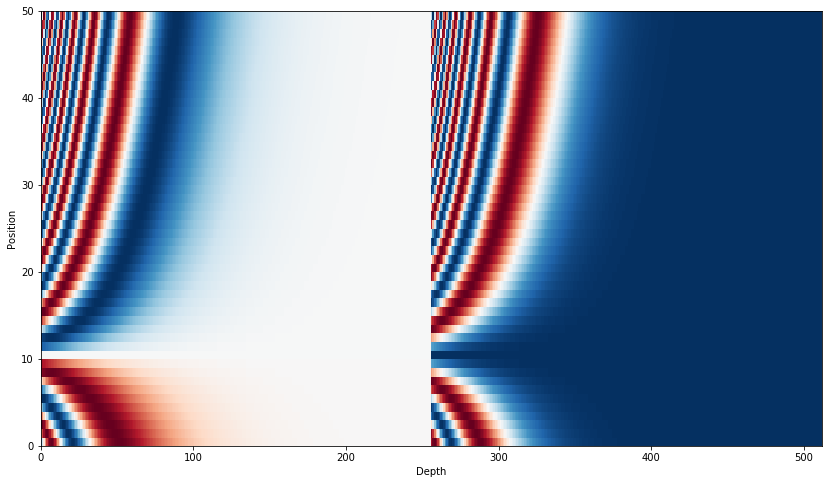

In [15]:
plt.figure(figsize=(14,8))
plt.pcolormesh(np.dot(pos_encoding, update), cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')

考虑到数值精确度，这个结果近乎正确。

In [16]:
errors = np.dot(pos_encoding, update)[10:] - pos_encoding[:-10]
abs(errors).max()

5.4262150328554526e-15